## VAR model ver 1
using actual shortlisted variables

In [191]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

In [192]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

In [193]:
list_of_variables = ['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
hrc = ['Date', 'HRC (FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Date,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
0,2006-09-01,472,59,116,252,14.277778,24.3,24.0,6.0,34.2,3.9
1,2006-10-01,477,62,85,260,13.657895,24.1,25.1,11.4,31.8,6.7
2,2006-11-01,470,62,84,262,16.078947,24.0,26.1,8.3,28.9,7.2
3,2006-12-01,470,61,90,270,15.512821,21.8,27.0,13.1,15.8,16.1
4,2007-01-01,470,62,98,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [194]:
df.columns.values

array(['Date', 'HRC (FOB, $/t)', 'Iron Ore (CFR, $/t)',
       'HCC (Aus FOB, $/t)', 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
       'Monthly Export of Semis & Finished Steel as % of Production',
       'FAI in urban real estate development (y-o-y) Growth',
       'Automobile Production (y-o-y)',
       'Civil Metal-Vessels/Steel Ships (y-o-y)',
       'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'],
      dtype=object)

In [195]:
final_df = df.copy()
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
Date,,,,,,,,,,
2006-09-01,472,59,116,252,14.277778,24.3,24.0,6.0,34.2,3.9
2006-10-01,477,62,85,260,13.657895,24.1,25.1,11.4,31.8,6.7
2006-11-01,470,62,84,262,16.078947,24.0,26.1,8.3,28.9,7.2
2006-12-01,470,61,90,270,15.512821,21.8,27.0,13.1,15.8,16.1
2007-01-01,470,62,98,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [196]:
# Split dataset into train and test set
final_df_train, final_df_test = final_df[0:-17], final_df[-17:]

print(final_df_train.shape)
print(final_df_test.shape)

(201, 10)
(17, 10)


In [197]:
# Difference data to achieve stationarity
def log_trans(df):
    negative_cols = df.columns[df.min() < 0]

    df_transformed = df.copy()
    negative_cols_data = {}
    for col in negative_cols:
        constant = abs(df[col].min()) + 1
        df_transformed[col] = np.log(df[col] + constant)
        negative_cols_data[str(col)+'_forecast'] = constant

    for col in df.columns.difference(negative_cols):
        df_transformed[col] = np.log(df[col])
    
    return df_transformed, negative_cols_data

# final_df_train_transformed, negative_cols_data = log_trans(final_df_train)
final_df_train_differenced = final_df_train.diff().dropna()

In [198]:
# Determine the best number of lags
model = VAR(final_df_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,45.13,45.30*,3.965e+19,45.20*
1,44.92,46.82,3.245e+19*,45.69
2,45.02,48.64,3.611e+19,46.49
3,45.19,50.52,4.334e+19,47.35
4,45.32,52.38,5.157e+19,48.18
5,45.52,54.29,6.721e+19,49.07
6,45.64,56.14,8.449e+19,49.89
7,45.97,58.20,1.372e+20,50.93
8,46.11,60.05,1.930e+20,51.76
9,46.22,61.89,2.864e+20,52.57


In [199]:
# Print the optimal lag order based on AIC / BIC
print(x.aic, x.bic, x.hqic)  

12 0 0


In [200]:
# Use lag with the lowest AIC
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Mar, 2025
Time:                     23:09:29
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    57.8090
Nobs:                     193.000    HQIC:                   50.6670
Log likelihood:          -6448.86    FPE:                1.12346e+20
AIC:                      45.8063    Det(Omega_mle):     4.89881e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  1.118319         2.031441            0.551  

In [201]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.99
Iron Ore (CFR, $/t) : 2.0
HCC (Aus FOB, $/t) : 2.03
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.16
Monthly Export of Semis & Finished Steel as % of Production : 1.96
FAI in urban real estate development (y-o-y) Growth : 1.97
Automobile Production (y-o-y) : 2.01
Civil Metal-Vessels/Steel Ships (y-o-y) : 1.96
Household Fridges (y-o-y) : 2.02
Air Conditioner (y-o-y) : 1.98


In [202]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train_differenced.values[-lag_order:]
forecast_input

array([[-25.        ,   1.        ,  -8.        ,  -9.        ,
          0.96020143,  -1.        ,  -2.5       ,  -3.        ,
         -0.4       ,  -1.2       ],
       [ 49.        ,  18.        , -19.        ,  43.        ,
         -0.51982012,  -0.2       ,  -2.2       ,   0.6       ,
          0.1       ,  -0.2       ],
       [ 48.        ,  12.        ,  55.        ,  24.        ,
          7.85130395,   4.3       , -17.4       , -17.4       ,
         11.5       ,   9.        ],
       [ 25.        ,   3.        ,  51.        ,   3.        ,
         -4.57136237,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 19.        ,   1.        , -24.        ,  -1.        ,
         -1.89663462,  -0.1       ,   8.9       ,  14.        ,
          0.5       ,   1.8       ],
       [-43.        , -11.        , -76.        , -25.        ,
          0.30813172,  -0.4       ,   9.4       ,   8.4       ,
          2.6       ,  -0.4       ],
       [-6

In [203]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=34)
fc_period = pd.date_range(start='6/1/2023', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_1d')
df_forecast.index.name = 'Date'
df_forecast

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d
Date,,,,,,,,,,
2023-06-01,-38.274353,2.080663,-40.250011,-17.383615,-0.088987,-3.661895,-2.965799,8.627490,-5.855573,-3.179435
2023-07-01,-31.055701,2.772130,-25.779355,-44.800824,-1.292840,-2.687677,-11.036882,2.815380,-4.307061,-6.895390
2023-08-01,-13.158591,-22.013373,22.588037,12.873147,-1.249000,2.002586,3.652886,1.543206,-1.393753,4.375341
2023-09-01,9.584451,1.623242,35.321983,34.455500,-0.255729,-1.013908,2.318351,-8.637686,2.175503,-2.041325
2023-10-01,40.065126,6.478666,29.084995,23.090081,0.977486,-0.871622,-3.927562,-7.990730,1.867150,-0.399852
2023-11-01,37.107204,5.458122,-1.936384,6.795566,0.236222,0.095550,-2.911348,1.469834,0.997598,-0.141449
2023-12-01,14.729790,-2.524271,-2.620962,10.369657,0.625545,2.464167,9.529594,4.877240,2.369346,4.735478
2024-01-01,8.801561,9.575637,-2.572900,2.990167,1.036320,0.178057,-3.932372,0.245955,-0.817634,-2.666973
2024-02-01,-4.173511,-0.264800,13.837333,-23.548819,0.865614,0.733093,1.861374,-3.229174,-0.861877,1.938646


In [204]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df_train, df_forecast)

In [205]:
# def exp_trans(df, negative_cols_data):
#     df_transformed = df.copy()
#     for col in negative_cols_data.keys():
#         df_transformed[col] = np.exp(df[col]) - negative_cols_data[col]

#     for col in df.columns.difference(negative_cols_data.keys()):
#         df_transformed[col] = np.exp(df[col])
    
#     return df_transformed

# df_forecast_processed = exp_trans(df_forecast_processed, negative_cols_data)

In [206]:
df_forecast1, df_forecast2 = df_forecast_processed[0:-17], df_forecast_processed[-17:]
final_df.index = pd.to_datetime(final_df.index)
final_df_train.index = pd.to_datetime(final_df_train.index)
final_df_test.index = pd.to_datetime(final_df_test.index)

df_forecast2.to_csv('../data/final/var_forecast.csv', index=True)

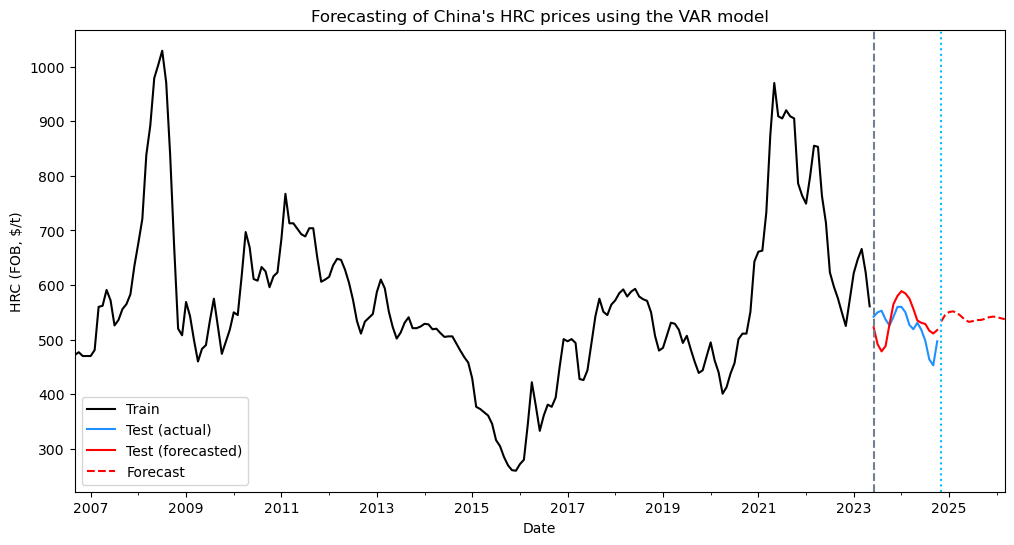

In [207]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_train['HRC (FOB, $/t)'].plot(color='k', label='Train')
final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')
df_forecast2['HRC (FOB, $/t)_forecast'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2023-06-01', color = 'slategray', linestyle = 'dashed')
plt.axvline(x = '2024-11-01', color = 'deepskyblue', linestyle = 'dotted')
ax.legend()

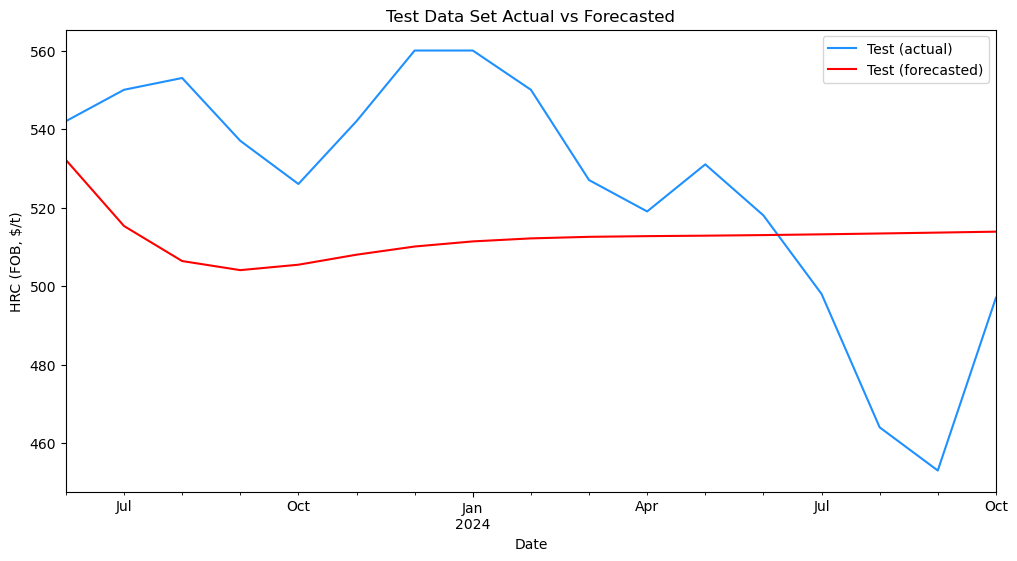

In [190]:
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')

plt.title("Test Data Set Actual vs Forecasted")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

In [187]:
# Error metrics

forecast = df_forecast1['HRC (FOB, $/t)_forecast'].values
actual = final_df_test['HRC (FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  25.733214114323506
Root Mean Squared Error:  32.031503358041704
Mean Absolute Percentage Error:  0.050612869320899534


### Impulse Response Analysis

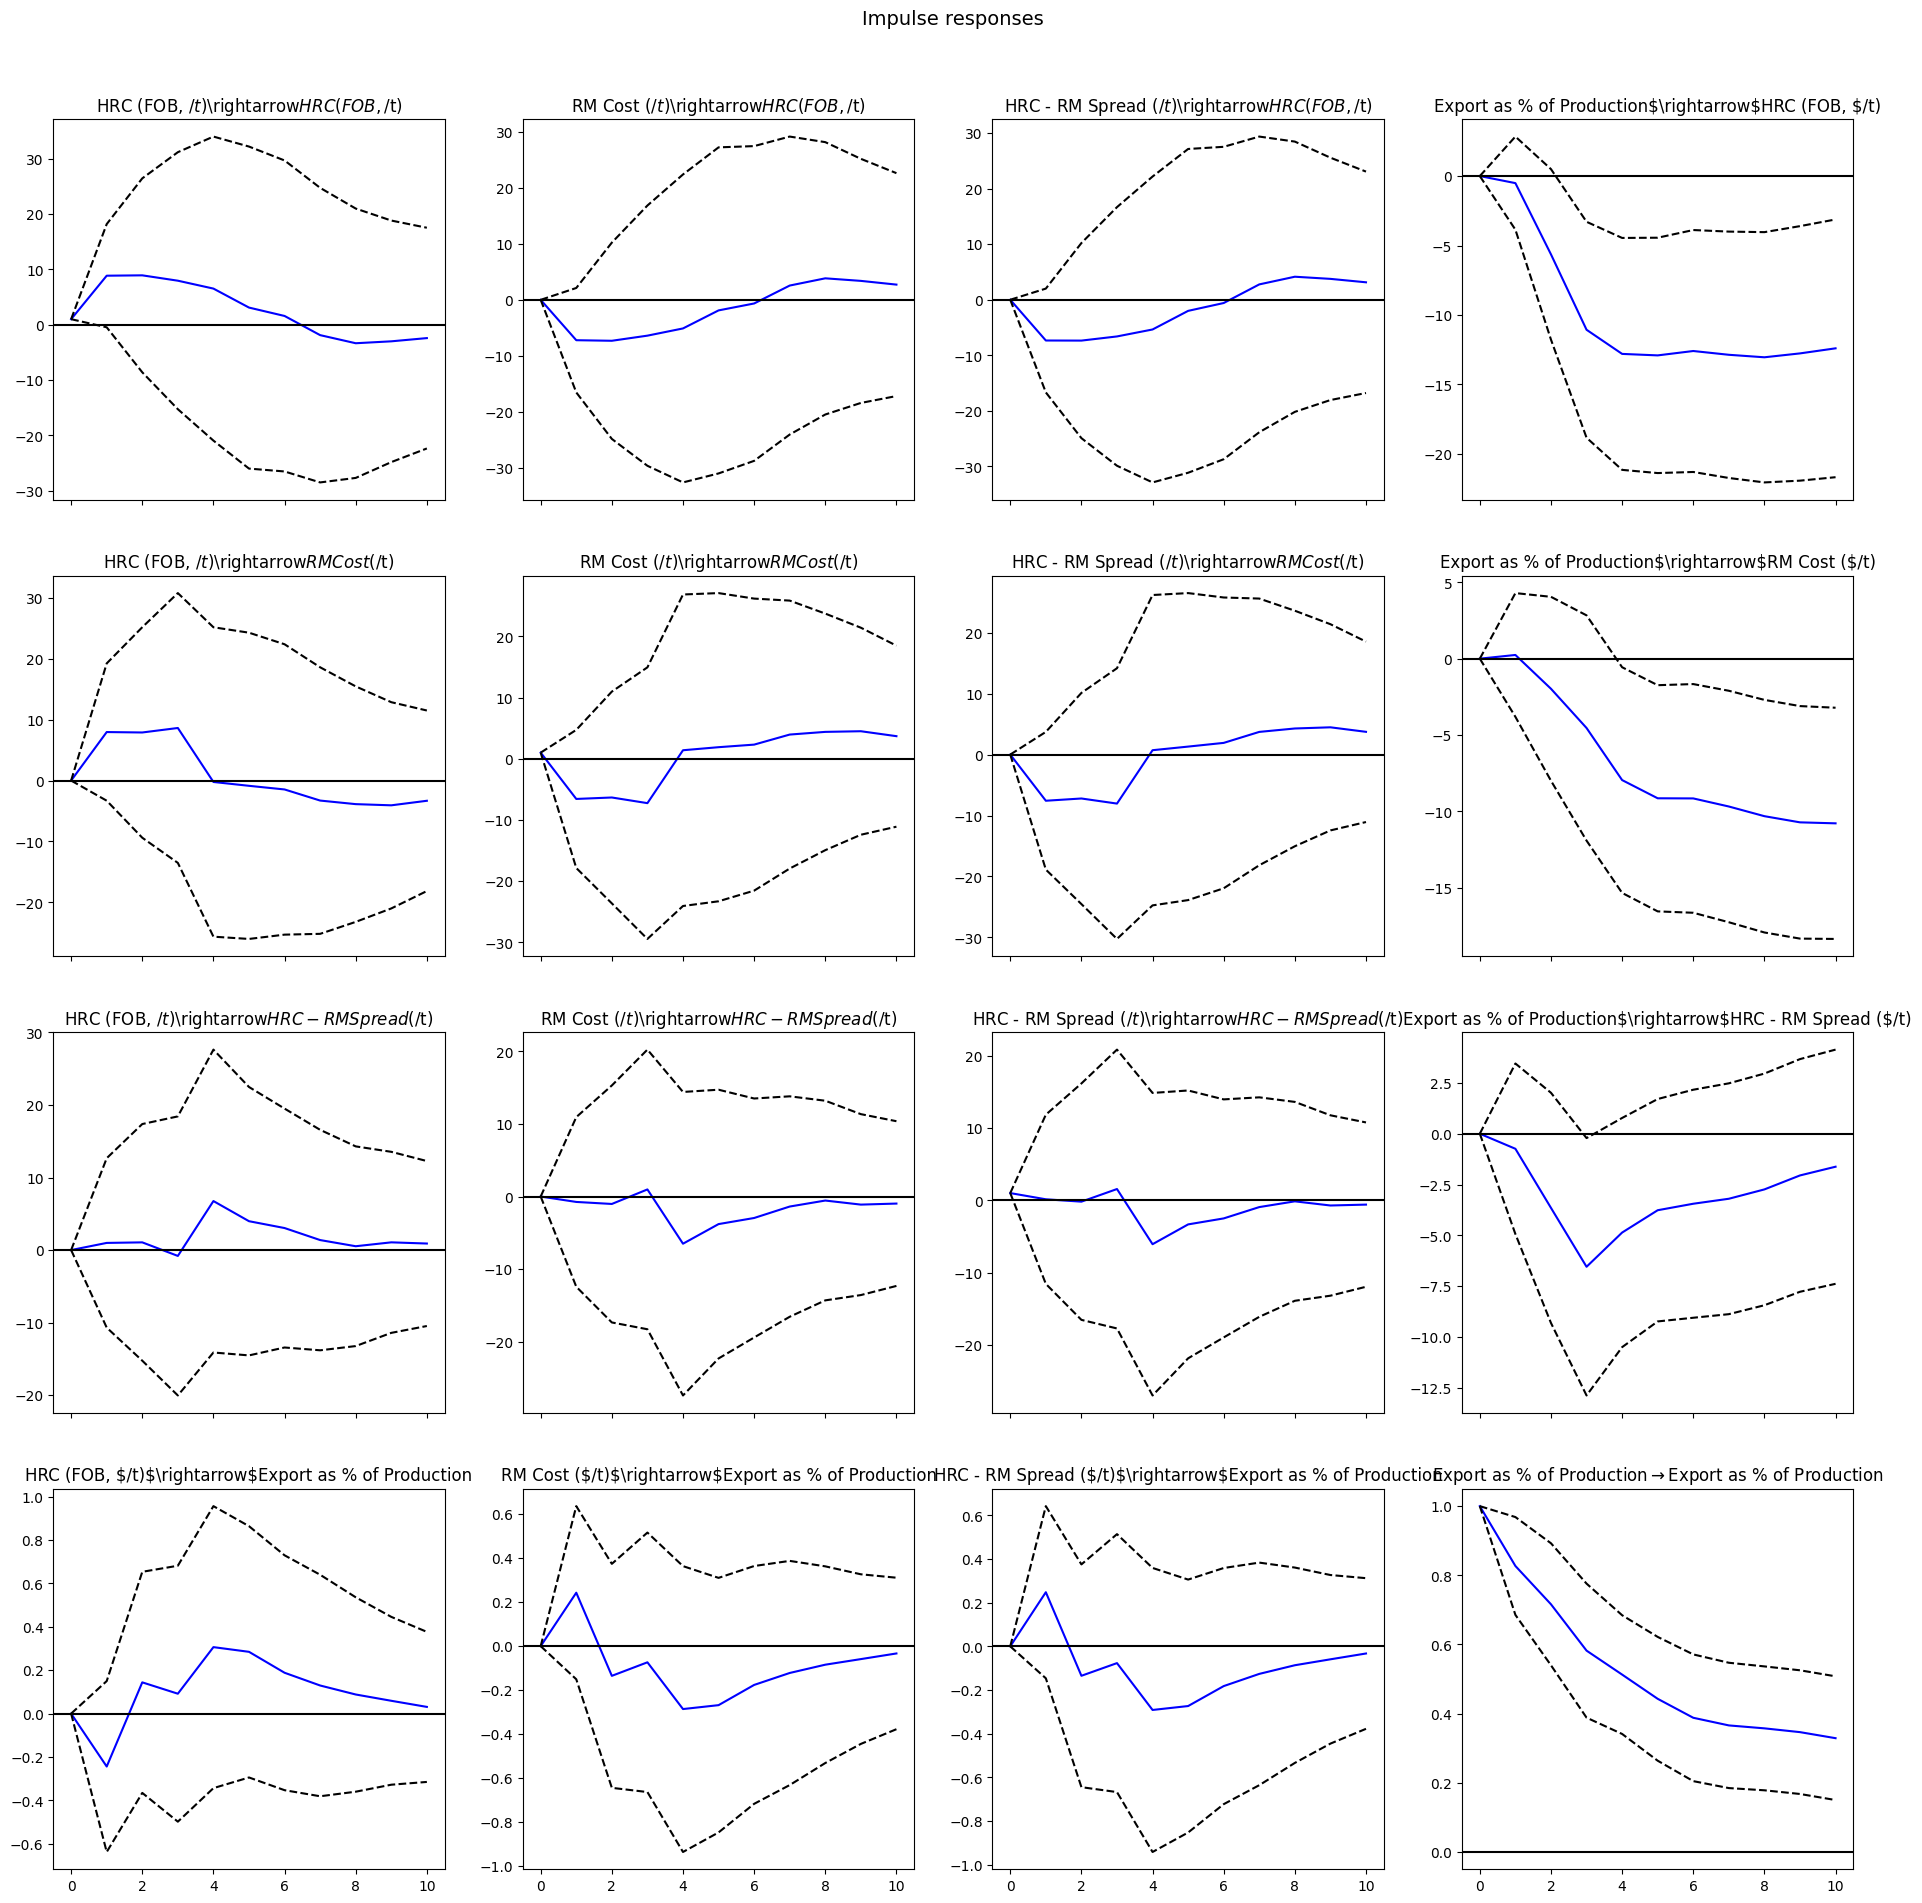

In [33]:
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()

## VAR Model ver 2
using actual variables, using whole data set as train data set to predict the prices

In [34]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()

,Date,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
0,2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
1,2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2,2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
3,2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
4,2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [35]:
final_df = df.copy()
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC (FOB, $/t)","Iron Ore (CFR, $/t)","HCC (Aus FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),HRC - RM Spread ($/t),Monthly Export of Semis & Finished Steel as % of Production,FAI in urban real estate development (y-o-y) Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
Date,,,,,,,,,,,
2006-09-01,472,59,116,252,261,14.277778,24.3,24.0,6.0,34.2,3.9
2006-10-01,477,62,85,260,292,13.657895,24.1,25.1,11.4,31.8,6.7
2006-11-01,470,62,84,262,288,16.078947,24.0,26.1,8.3,28.9,7.2
2006-12-01,470,61,90,270,282,15.512821,21.8,27.0,13.1,15.8,16.1
2007-01-01,470,62,98,273,273,13.026316,24.3,45.0,8.6,15.8,16.1


In [36]:
# Difference data to achieve stationarity
final_df_differenced = final_df.diff().dropna()

In [37]:
# Determine the best number of lags
model = VAR(final_df_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.65,44.83*,2.464e+19,44.72*
1,44.22,46.36,1.601e+19*,45.08
2,44.26,48.36,1.677e+19,45.91
3,44.47,50.53,2.131e+19,46.92
4,44.58,52.61,2.495e+19,47.83
5,44.81,54.79,3.362e+19,48.84
6,44.91,56.85,4.191e+19,49.74
7,45.29,59.20,7.293e+19,50.92
8,45.53,61.40,1.176e+20,51.95
9,45.60,63.43,1.722e+20,52.81


In [38]:
# Use lag with the lowest AIC
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     11:11:12
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    52.2011
Nobs:                     213.000    HQIC:                   47.5465
Log likelihood:          -7557.07    FPE:                2.03720e+19
AIC:                      44.3896    Det(Omega_mle):     2.47396e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.739229         1.813142            0.408  

In [39]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.99
Iron Ore (CFR, $/t) : 2.01
HCC (Aus FOB, $/t) : 2.02
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.04
HRC - RM Spread ($/t) : 2.04
Monthly Export of Semis & Finished Steel as % of Production : 2.03
FAI in urban real estate development (y-o-y) Growth : 1.93
Automobile Production (y-o-y) : 1.95
Civil Metal-Vessels/Steel Ships (y-o-y) : 2.0
Household Fridges (y-o-y) : 1.99
Air Conditioner (y-o-y) : 1.98


In [40]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_differenced.values[-lag_order:]
forecast_input

array([[-20.        ,  -1.        , -12.        ,  -2.        ,
         -6.        ,  -0.07713463,  -0.1       ,  -1.2       ,
          0.1       ,  -2.4       ,  -4.3       ],
       [-34.        ,  -7.        , -31.        , -30.        ,
          8.        ,   2.74575224,   0.        ,  -1.1       ,
         -0.3       ,   0.        ,  -1.7       ],
       [-11.        ,  -5.        , -19.        ,  -9.        ,
         16.        ,   1.002331  ,   0.1       ,  -0.7       ,
          0.        ,   0.2       ,   0.2       ],
       [ 44.        ,  10.        ,  17.        ,  17.        ,
         11.        ,   0.45232816,  -0.2       ,   0.3       ,
          0.2       ,   1.        ,   0.2       ]])

In [41]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=17)
fc_period = pd.date_range(start='11/1/2024', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df.columns + '_1d')
df_forecast

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d
2024-11-01,20.629309,2.364135,30.606483,-2.095533,-13.850191,-0.240211,2.312848,6.909955,-0.237175,3.335110,3.012363
2024-12-01,3.183629,0.756695,18.141636,3.016373,-16.268366,-0.266579,1.011927,2.975016,2.456900,1.220875,1.872752
2025-01-01,8.158597,2.134464,-2.464243,10.600086,7.196443,0.265099,-1.075465,-2.072225,-0.255907,-2.098807,-0.707824
2025-02-01,12.827367,2.514066,-7.826123,3.291034,16.726751,0.428827,-0.305621,-1.981106,-1.334121,-0.927459,-0.257606
2025-03-01,7.637114,3.401677,1.739465,1.878800,0.542324,0.220440,0.164124,0.410519,0.590534,0.871490,0.888513
2025-04-01,-2.249667,-0.552508,3.032983,-3.336587,-4.439723,-0.029160,0.200496,0.105462,0.810661,0.196828,0.685868
2025-05-01,-5.558351,-2.557431,0.226096,-3.830762,-1.728715,-0.202938,0.182532,-0.209631,0.459154,-0.440417,-0.085983
2025-06-01,-1.823958,-1.597611,-1.359309,0.237479,2.113568,-0.067968,-0.379584,-0.774145,-0.996796,-0.609911,-0.380049
2025-07-01,0.394816,0.108253,-1.989427,1.250267,2.258856,0.059567,-0.428865,-1.004499,-0.728719,-0.341489,-0.380746
2025-08-01,0.041512,0.636509,0.703261,0.752172,-1.701948,0.027693,-0.234788,-0.052766,0.056361,0.231621,-0.031420


In [42]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df, df_forecast)
df_forecast_processed

,"HRC (FOB, $/t)_1d","Iron Ore (CFR, $/t)_1d","HCC (Aus FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,HRC - RM Spread ($/t)_1d,Monthly Export of Semis & Finished Steel as % of Production_1d,FAI in urban real estate development (y-o-y) Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,...,"Iron Ore (CFR, $/t)_forecast","HCC (Aus FOB, $/t)_forecast",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast,HRC - RM Spread ($/t)_forecast,Monthly Export of Semis & Finished Steel as % of Production_forecast,FAI in urban real estate development (y-o-y) Growth_forecast,Automobile Production (y-o-y)_forecast,Civil Metal-Vessels/Steel Ships (y-o-y)_forecast,Household Fridges (y-o-y)_forecast,Air Conditioner (y-o-y)_forecast
2024-11-01,20.629309,2.364135,30.606483,-2.095533,-13.850191,-0.240211,2.312848,6.909955,-0.237175,3.335110,...,106.364135,234.606483,351.904467,113.149809,13.393935,-7.987152,9.909955,1.062825,11.835110,11.212363
2024-12-01,3.183629,0.756695,18.141636,3.016373,-16.268366,-0.266579,1.011927,2.975016,2.456900,1.220875,...,107.120830,252.748119,354.920840,96.881442,13.127356,-6.975225,12.884971,3.519725,13.055985,13.085115
2025-01-01,8.158597,2.134464,-2.464243,10.600086,7.196443,0.265099,-1.075465,-2.072225,-0.255907,-2.098807,...,109.255295,250.283876,365.520926,104.077886,13.392455,-8.050690,10.812746,3.263818,10.957178,12.377291
2025-02-01,12.827367,2.514066,-7.826123,3.291034,16.726751,0.428827,-0.305621,-1.981106,-1.334121,-0.927459,...,111.769360,242.457754,368.811959,120.804637,13.821283,-8.356311,8.831641,1.929697,10.029718,12.119685
2025-03-01,7.637114,3.401677,1.739465,1.878800,0.542324,0.220440,0.164124,0.410519,0.590534,0.871490,...,115.171038,244.197219,370.690759,121.346960,14.041723,-8.192186,9.242159,2.520230,10.901208,13.008198
2025-04-01,-2.249667,-0.552508,3.032983,-3.336587,-4.439723,-0.029160,0.200496,0.105462,0.810661,0.196828,...,114.618530,247.230202,367.354172,116.907238,14.012563,-7.991691,9.347622,3.330891,11.098037,13.694066
2025-05-01,-5.558351,-2.557431,0.226096,-3.830762,-1.728715,-0.202938,0.182532,-0.209631,0.459154,-0.440417,...,112.061099,247.456298,363.523410,115.178522,13.809625,-7.809159,9.137991,3.790045,10.657619,13.608084
2025-06-01,-1.823958,-1.597611,-1.359309,0.237479,2.113568,-0.067968,-0.379584,-0.774145,-0.996796,-0.609911,...,110.463488,246.096988,363.760888,117.292090,13.741656,-8.188743,8.363846,2.793249,10.047709,13.228035
2025-07-01,0.394816,0.108253,-1.989427,1.250267,2.258856,0.059567,-0.428865,-1.004499,-0.728719,-0.341489,...,110.571741,244.107561,365.011155,119.550946,13.801224,-8.617608,7.359347,2.064530,9.706220,12.847289
2025-08-01,0.041512,0.636509,0.703261,0.752172,-1.701948,0.027693,-0.234788,-0.052766,0.056361,0.231621,...,111.208250,244.810821,365.763328,117.848998,13.828916,-8.852396,7.306581,2.120891,9.937841,12.815869


In [43]:
final_df.index = pd.to_datetime(final_df.index)

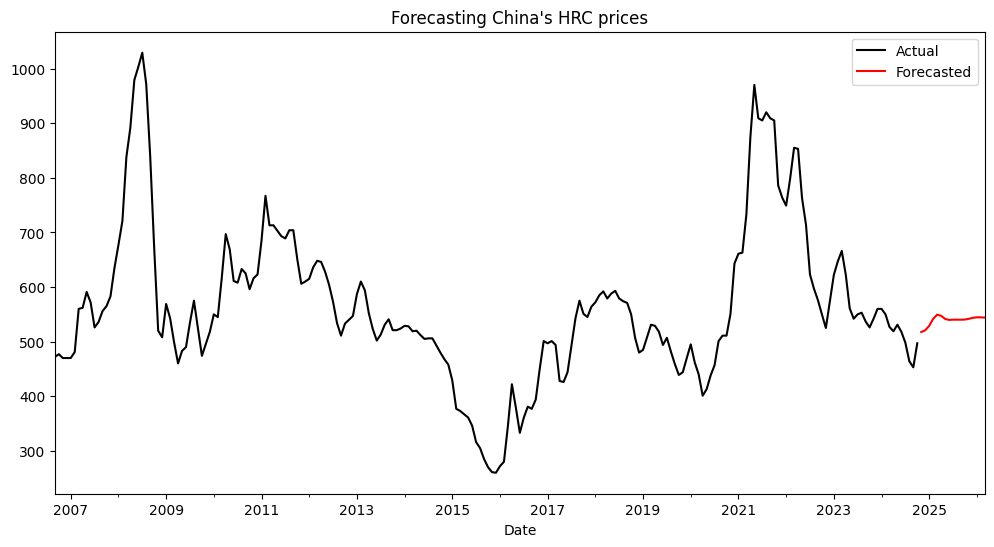

In [44]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df['HRC (FOB, $/t)'].plot(color='k', label='Actual')
df_forecast_processed['HRC (FOB, $/t)_forecast'].plot(color='r', label='Forecasted')

plt.title("Forecasting China's HRC prices")
ax.legend()

In [45]:
'''
## VAR Model ver 2
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()
### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df_test.index, columns=final_df_test.columns + '_f')
df_forecast
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()
# Error metrics

forecast = df_forecast['HRC \n(FOB, $/t)_f'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)
### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.
### Impulse Response Analysis
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()
'''

"\n## VAR Model ver 2\n# Read csv\nfile_path = '../data/final/wo_na.csv'\ndf = pd.read_csv(file_path)\ndf.head()\n### Section to be replaced by feature selection / granger causality test\n\nFor the sake of testing the VAR model, I will select a few stationary variables from the ADF test:\n\n1. RM Cost ($/t)\n2. HRC - RM Spread ($/t)\n3. Export as % of Production\nlist_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']\nhrc = ['Month_Dt', 'HRC \n(FOB, $/t)']\nfinal_cols = hrc + list_of_variables\n\ndf = df[final_cols]\ndf.head()\n# Set date column as the index\nfinal_df = df.copy()\nfinal_df = final_df.rename(columns={'Month_Dt':'Date'})\nfinal_df.set_index('Date', inplace=True)\n\nfinal_df.head()\n# Split dataset into train and test set\nnobs = 12 #setting the number of forecasted periods to 12 months / 1 year\nfinal_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]\n\nprint(final_df_train.shape)\nprint(final_df_test.shape)\n# Determi